SCC0270 - Redes Neurais e Aprendizado Profundo

Alunos:
- 10716504 - Helbert Moreira Pinto
- 10377708 - João Marcos Della Torre Divino

Exercicio 2 - Implemente uma rede MLP usando apenas pacotes básicos do Python, como a biblioteca Numpy.

No exercÍcio anterior implementamos o perceptron que consegue encontrar um plano separador entre dois conjuntos, desde que os elementos dos conjuntos sejam linearmente separáveis.  
Vemos abaixo duas associações de conjuntos. Na primeira temos conjuntos linearmente separáveis (existe um plano separador entre eles) e na segunda não temos um plano que separe ambos conjuntos.   
<img src='imgs/separaveis.png' alt='Linearmente separável' width='1000'/>

Como a maioria dos problemas reais exigem soluções não linearmente separaveis, temos uma limitação considerável no uso do perceptron.  
Como exemplo podemos citar o problema do XOR (Exclusive OR) que possui a seguinte tabela verdade:

| A | B | S |
|:-:|:-:|:-:|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Para uma melhor comparação, vemos graficamente lado a lado como são os casos do AND, do OR e do XOR:  
<img src='imgs/xor2.png' alt='Linearmente separável' width='500'/>


Para a solução deste problema, foi proposto a construção de uma rede de perceptrons, onde a saída dos perceptrons da camada atual alimenta os perceptrons de camadas posteriores, conhecido por MLP (MultiLayer Perceptron). A cada camada de processamento da rede é adicionado um novo plano separador dos conjuntos, resolvendo deste modo problemas que não são linearmente separaveis.  
<img src='imgs/mlp.png' alt='Linearmente separável' width='500'/>

A implementação da etapa de propagação para a saida é dado pelo seguinte trecho do código:  
```python
def feedforward(u, fa=sigmoide):
    # array A armazena os valores das saidas das camadas
    A = [np.array(u)]
    for peso, bias in zip(pesos, bias):
        u = fa(np.dot(u, peso) + bias)
        A.append(u)
    return u, A
```
Nota-se que deixamos a função de ativação parametrizavel, pois poderiamos usar a função de tangente hiperbolica (caso tivesse valores negativos em nosso conjunto de dados).

Diferentemente do perceptron simples, onde o erro da saída estava diretamente relacionado aos pesos do próprio perceptron, no MLP o erro da saída é indiretamente influenciado por uma pequena parcela de todos os neurônios que compõe a rede. Deste modo o ajuste dos pesos deve ser feito da camada de saída (onde o erro pode ser mensurado) para as camadas anteriores. O nome deste processo de retropropagação do erro é conhecida por backpropagation.

O algoritmo de backpropagation é baseado na ideia de ajustes dos pesos na direção de minimização da função de custo (que neste caso é a saida esperada - saida observada).  
```python
def diferenca_vetorial(a, b):
    return a - b
```

Para encontrar a direção de minimização da função de custo usa-se o gradiente descendente, como pode ser visto na figura abaixo.  
<img src='imgs/gradiente.png' alt='Linearmente separável' width='500'/>

Em nossa implementação utilizamos a regra delta para calcularmos os gradientes dos pesos:

$\delta_0 = erro \cdot \frac {d} {dx} fa(A_n)$

$\delta_i = \delta_{i-1} \cdot W^{T}_{i} \cdot \frac {d} {dx} fa(A_{i}), i = 1, 2, 3, ... , n-1$

onde:

$fa$ = função de ativação (sigmóide)

$W_i$ = pesos da camada i

$A_i$ = vetor de saída da camada i 

Após os calculos dos deltas, os gradientes podem ser calculados como:

$\nabla W_i = \delta_{n-i} \cdot A_i, i = 0,1,2,...,n$

A implementação de retropropagação dos erros ficou do seguinte modo:
```python
def backpropagation(amostra, taxa, fa=sigmoide, dfa=dsigmoide, funcao_custo=diferenca_vetorial):
    x, y = amostra
    saida, a = feedforward(x, fa)
    erro = funcao_custo(y, saida)

    # ajustar pesos e bias
    # calcular os deltas da camada de saida para a camada de entrada
    delta = [erro * dfa(saida)]
    for i in range(len(a)-1, 0, -1):
        delta_i = delta[len(delta)-1].dot(pesos[i-1].T) * dfa(a[i-1])
        delta.append(delta_i)
    # revertendo os deltas
    delta = delta[::-1][1:]

    # calculando os gradientes e aplicando alterações nos pesos
    # w = w + (taxa * (entrada . delta))
    for i, w in enumerate(pesos):
    # bug da unidimensionalidade -> a[i].T
        if len(a[i].shape) == 1:
            a[i] = a[i].reshape(1, len(a[i]))
        w += (taxa * np.dot(a[i].T, delta[i]))

    # aplicando alterações nos bias
    # b = b + (taxa * (1 . delta))
    for i, b in enumerate(bias):
        b += (taxa * delta[i])
    return
```

Para treino da nossa rede, utilizamos o algoritmo conforme imagem abaixo, na seguinte ordem:  
- apresentar uma amostra
- calcular o erro observado
- calcular os deltas e gradientes
- ajustar os pesos e os bias 
- apresentar nova amostra e voltar ao passo 1

<img src='imgs/treino-mlp.png' alt='Linearmente separável' width='500'/>

A implementação da etapa de treino é dado pelo seguinte código:
```python
def treino(amostras, lim_erro=1e-3, taxa=0.5, funcao_custo=diferenca_vetorial):
    epoca = 0
    erro_epoca = []

    while True:
        erro_epoca = []

        for amostra in amostras:
            x, y = amostra
            saida, _ = feedforward(x)
            erro_epoca.append(funcao_custo(y, saida))
            backpropagation(amostra, taxa=taxa)
        
        # erro quadratico medio
        mse = np.sum(np.square(erro_epoca)) / len(erro_epoca)
        erro_epoca.append(mse)
        
        # a cada 5k epocas exibe o erro quadratico medio da epoca
        if epoca % 5000 == 0:
            print('Epoca: {:06d} | MSE: {:.8f}'.format(epoca, mse))
        
        # condição de parada: erro quadratico medio menor que um limite pre-estabelecido
        if mse < lim_erro:
            break
        
        epoca += 1
    
    return erro_epoca
```  

Inicialmente, utilizamos os dados do XOR como entrada, para ver se a rede estava conseguindo ajustar os pesos adequadamente.

In [1]:
from src.mlp import MLP
rede_xor = MLP([2,4,1])

xor = [
    ([0,0], [1]), 
    ([0,1], [0]), 
    ([1,0], [0]), 
    ([1,1], [1]), 
]

Antes de treinarmos nossa rede, vemos que as saidas possuem valores aleatorios.

In [2]:
for x, _ in xor:
    y, _ = rede_xor.feedforward(x)
    print(f'{x} => {y}')

[0, 0] => [[0.43301737]]
[0, 1] => [[0.49526901]]
[1, 0] => [[0.46546778]]
[1, 1] => [[0.51971508]]


Na etapa de treinamento, com o decorrer das iterações, podemos a minimização da função de custo.

Epoca: 00000 | MSE: 0.25622553
Epoca: 05000 | MSE: 0.00562585
Epoca: 10000 | MSE: 0.00173718
Epoca: 14874 | MSE: 0.00099994


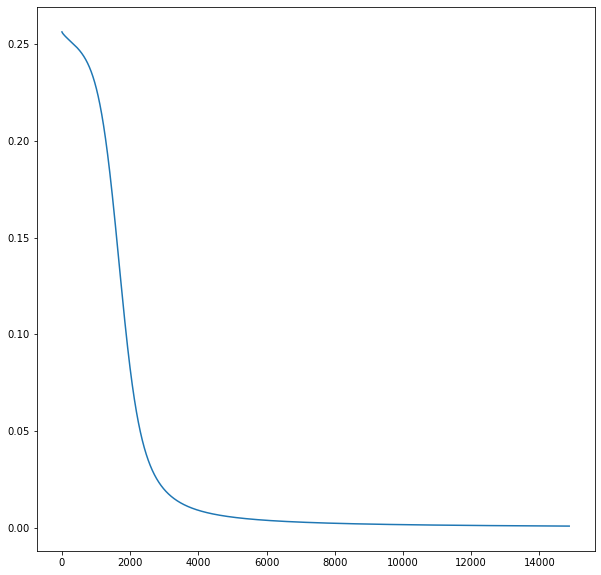

In [3]:
erro_epoca = rede_xor.treino(amostras=xor, taxa=0.1, lim_erro=1e-3)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

Por fim podemos ver se os pesos foram ajustados corretamente ao ver as saidas dada as entradas do XOR.

In [4]:
for x, _ in xor:
    y, _ = rede_xor.feedforward(x)
    print(f'{x} => {y}')

[0, 0] => [[0.98053896]]
[0, 1] => [[0.02729667]]
[1, 0] => [[0.03206453]]
[1, 1] => [[0.95702746]]


Como proposta do exercicio tinhamos que construir o mapeamento de caracteristicas, utilizando como padrão de entrada e saída:
- $Id_8$: Identidade de ordem 8 ou Id(8x8)
- $Id_{16}$: Identidade de ordem 16 ou Id(16x16)

Identidade 8

In [5]:
import numpy as np
from src.mlp import MLP
rede_id8 = MLP([8,3,8])

Id8 = [(z,z) for z in np.identity(8)]

for x, _ in Id8:
    y, _ = rede_id8.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0.] => [[0.65 0.19 0.78 0.25 0.31 0.62 0.09 0.43]]
[0. 1. 0. 0. 0. 0. 0. 0.] => [[0.75 0.15 0.78 0.38 0.28 0.82 0.04 0.42]]
[0. 0. 1. 0. 0. 0. 0. 0.] => [[0.74 0.23 0.75 0.27 0.43 0.8  0.1  0.51]]
[0. 0. 0. 1. 0. 0. 0. 0.] => [[0.69 0.21 0.81 0.27 0.44 0.65 0.04 0.39]]
[0. 0. 0. 0. 1. 0. 0. 0.] => [[0.75 0.19 0.76 0.32 0.33 0.82 0.08 0.48]]
[0. 0. 0. 0. 0. 1. 0. 0.] => [[0.73 0.25 0.78 0.25 0.52 0.75 0.07 0.47]]
[0. 0. 0. 0. 0. 0. 1. 0.] => [[0.71 0.14 0.77 0.35 0.2  0.77 0.07 0.43]]
[0. 0. 0. 0. 0. 0. 0. 1.] => [[0.65 0.13 0.77 0.3  0.16 0.68 0.11 0.43]]


Epoca: 00000 | MSE: 1.98064155
Epoca: 05000 | MSE: 0.00586877
Epoca: 10000 | MSE: 0.00263138
Epoca: 15000 | MSE: 0.00167374
Epoca: 20000 | MSE: 0.00122047
Epoca: 24021 | MSE: 0.00099996


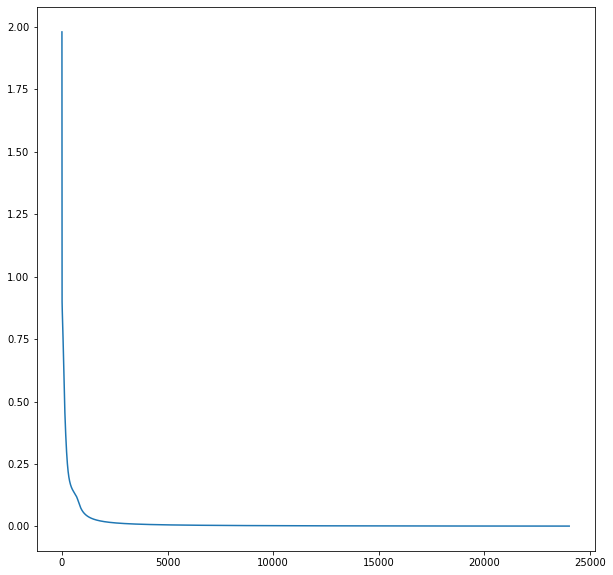

In [6]:
erro_epoca = rede_id8.treino(amostras=Id8, taxa=0.5, lim_erro=1e-3)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

In [7]:
for x, _ in Id8:
    y, _ = rede_id8.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0.] => [[0.97 0.   0.02 0.01 0.02 0.   0.   0.01]]
[0. 1. 0. 0. 0. 0. 0. 0.] => [[0.   0.98 0.   0.01 0.   0.   0.   0.  ]]
[0. 0. 1. 0. 0. 0. 0. 0.] => [[0.02 0.   0.98 0.   0.   0.02 0.   0.  ]]
[0. 0. 0. 1. 0. 0. 0. 0.] => [[0.02 0.02 0.   0.98 0.   0.   0.   0.01]]
[0. 0. 0. 0. 1. 0. 0. 0.] => [[0.01 0.01 0.   0.   0.98 0.01 0.   0.  ]]
[0. 0. 0. 0. 0. 1. 0. 0.] => [[0.   0.02 0.01 0.   0.01 0.98 0.01 0.  ]]
[0. 0. 0. 0. 0. 0. 1. 0.] => [[0.   0.01 0.   0.   0.   0.01 0.98 0.01]]
[0. 0. 0. 0. 0. 0. 0. 1.] => [[0.01 0.   0.01 0.01 0.   0.   0.02 0.98]]


Identidade 16

In [8]:
import numpy as np
from src.mlp import MLP
rede_id16 = MLP([16,4,16])

Id16 = [(z,z) for z in np.identity(16)]

for x, _ in Id16:
    y, _ = rede_id16.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.69 0.83 0.48 0.48 0.3  0.13 0.19 0.49 0.   0.66 0.68 0.14 0.03 0.38
  0.11 0.13]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.65 0.74 0.51 0.43 0.44 0.11 0.19 0.43 0.   0.55 0.66 0.19 0.03 0.43
  0.15 0.1 ]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.74 0.63 0.38 0.46 0.49 0.19 0.22 0.38 0.01 0.65 0.67 0.22 0.04 0.4
  0.19 0.1 ]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.81 0.71 0.34 0.52 0.41 0.26 0.22 0.41 0.01 0.75 0.68 0.17 0.04 0.33
  0.14 0.11]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.7  0.62 0.49 0.42 0.63 0.13 0.18 0.39 0.01 0.51 0.6  0.23 0.02 0.43
  0.15 0.07]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.72 0.71 0.47 0.44 0.46 0.14 0.18 0.48 0.01 0.6  0.6  0.17 0.02 0.41
  0.13 0.11]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.71 0.66 0.44 0.46 0.54 0.16 0.2  0.37 0.01 0.59 0.67 0.23 0.03 0.41
  0.17 0.08]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 

Epoca: 00000 | MSE: 1.91985496
Epoca: 05000 | MSE: 0.00770401
Epoca: 10000 | MSE: 0.00341375
Epoca: 15000 | MSE: 0.00217922
Epoca: 20000 | MSE: 0.00159666
Epoca: 25000 | MSE: 0.00125835
Epoca: 30000 | MSE: 0.00103761
Epoca: 31070 | MSE: 0.00100000


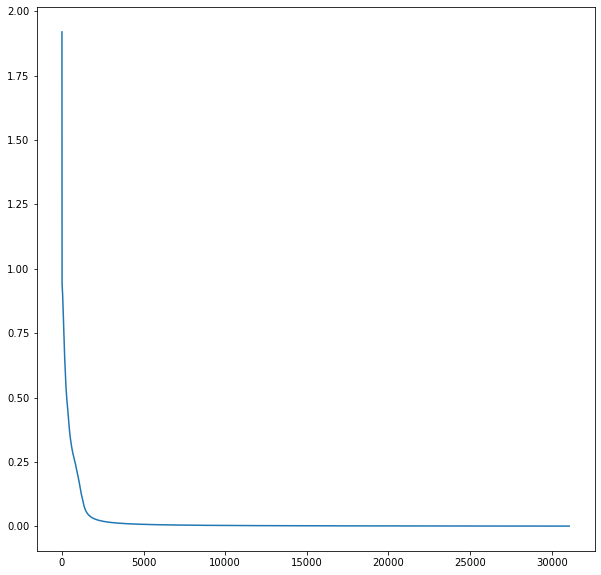

In [9]:
erro_epoca = rede_id16.treino(amostras=Id16, taxa=0.5, lim_erro=1e-3)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

In [10]:
for x, _ in Id16:
    y, _ = rede_id16.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.97 0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.
  0.01 0.  ]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.01 0.99 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.01 0.
  0.01 0.01]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.98 0.   0.01 0.01 0.   0.   0.   0.   0.   0.01 0.   0.
  0.   0.01]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.02 0.   0.   0.98 0.   0.01 0.01 0.   0.   0.01 0.   0.   0.   0.
  0.   0.  ]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.01 0.01 0.01 0.98 0.   0.   0.   0.   0.   0.   0.   0.01 0.
  0.   0.  ]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.   0.01 0.01 0.   0.98 0.   0.   0.01 0.   0.01 0.01 0.
  0.   0.  ]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0